In [1]:
import phoebe
import numpy as np
from spice.models.phoebe_model import PhoebeModel
from spice.spectrum import simulate_spectrum
from transformer_payne import Blackbody

PHOEBE: passband "Bolometric:900-40000" has a newer version available.  Run phoebe.list_passband_online_history("Bolometric:900-40000") to get a list of available changes and phoebe.update_passband("Bolometric:900-40000") or phoebe.update_all_passbands() to update.
PHOEBE: passband "Johnson:V" has a newer version available.  Run phoebe.list_passband_online_history("Johnson:V") to get a list of available changes and phoebe.update_passband("Johnson:V") or phoebe.update_all_passbands() to update.


In [2]:
import astropy.units as u
u.solRad.to(u.cm)

69570000000.0

In [3]:
4*np.pi*69570000000.0**2

6.082104402130212e+22

In [4]:
import matplotlib
%matplotlib inline

In [5]:
from phoebe.parameters.dataset import _mesh_columns

In [6]:
_mesh_columns

['volume',
 'xs',
 'ys',
 'zs',
 'vxs',
 'vys',
 'vzs',
 'nxs',
 'nys',
 'nzs',
 'us',
 'vs',
 'ws',
 'vus',
 'vvs',
 'vws',
 'nus',
 'nvs',
 'nws',
 'areas',
 'loggs',
 'teffs',
 'rprojs',
 'mus',
 'visibilities',
 'visible_centroids',
 'rs']

In [7]:
b = phoebe.default_star()
times = np.linspace(0, 24*3600, 10)
COLUMNS = _mesh_columns
b.add_dataset('mesh', times=times, columns=COLUMNS, dataset='mesh01')
b.run_compute(irrad_method='none')

100%|██████████| 10/10 [00:00<00:00, 161.56it/s]


<ParameterSet: 312 parameters | qualifiers: vvs, nys, mus, uvw_normals, uvw_elements, nxs, times, ys, xyz_elements, vs, rs, ws, nzs, visible_centroids, teffs, rprojs, vus, vzs, zs, vys, areas, vws, loggs, us, visibilities, xyz_normals, nvs, nus, volume, comments, xs, nws, vxs>

In [8]:
type(b)

phoebe.frontend.bundle.Bundle

In [9]:
[p.qualifier for p in b.__dict__['_params'] if 'faces' in p.qualifier]

[]

In [10]:
b.get_parameter(time=0., qualifier='uvw_elements').value.shape

(1710, 3, 3)

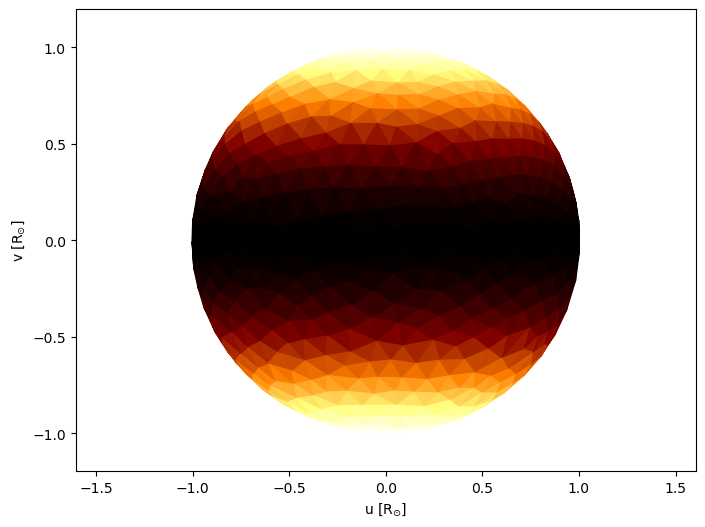

(<autofig.figure.Figure | 1 axes | 1 call(s)>,
 <Figure size 800x600 with 1 Axes>)

In [11]:
b.plot(dataset='mesh01', time=0.0, fc='teffs', ec='face', show=True)

In [12]:
from spice.models.phoebe_utils import PhoebeConfig

In [13]:
p = PhoebeConfig(b, 'mesh01')

In [14]:
b = Blackbody()
pm = PhoebeModel.construct(p, 0., b.parameter_names)

In [15]:
np.where(pm.mus>0, pm.mus, 0.)

array([0.        , 0.        , 0.        , ..., 0.14967675, 0.26919022,
       0.27236679])

In [16]:
pm.cast_areas

array([-2.03903093e+19, -4.07129678e+19, -2.02819073e+19, ...,
        4.06090679e+19,  8.07642671e+19,  1.38840141e+20])

In [17]:
ws = np.linspace(4000, 10000, 1000)
s = simulate_spectrum(b.intensity, pm, np.log10(ws))

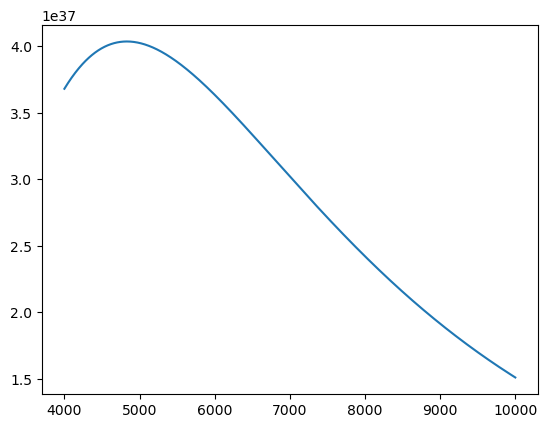

In [18]:
import matplotlib.pyplot as plt
plt.plot(ws, s[:, 0])

In [19]:
from spice.plots import plot_3D

(<Figure size 1000x1200 with 2 Axes>,
 <Axes3D: xlabel='$X [R_\\odot]$', ylabel='$Y [R_\\odot]$', zlabel='$Z [R_\\odot]$'>)

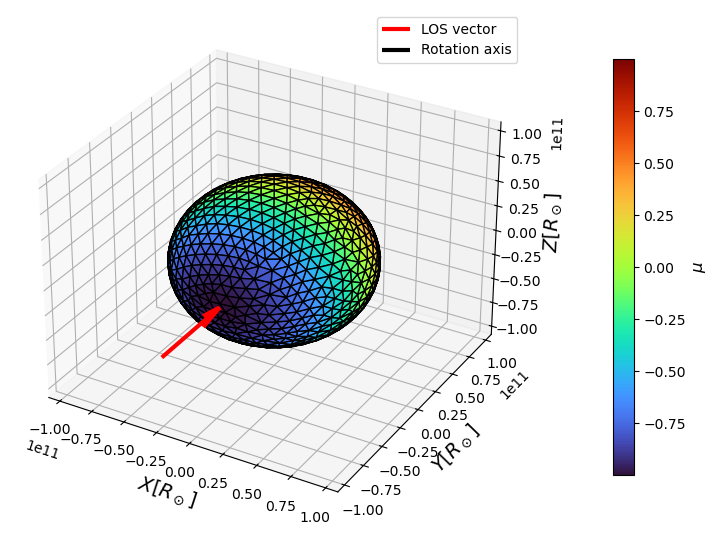

In [20]:
plot_3D(pm)

In [21]:
pm.rotation_axis

array([ 0.        ,  0.89399666, -0.44807362])